In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os

# Disable tokenizers parallelism to avoid the warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
!pip install -q -U watermark

In [5]:
!pip install -qq transformers

In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

numpy       : 1.24.3
pandas      : 2.1.4
torch       : 2.0.0
transformers: 4.36.0



In [7]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration


In [8]:
df_train = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Train.csv") 
df_train.head(10)

,Data,Label
0,মুগ্ধ হয়ে গেলাম মামু. আর তোমায় কি কমু. বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0
5,"যেমন : পরীক্ষার রেজাল্টের সময় , বিভিন্ন ব্যানি...",0
6,বিশ্বনন্দিত বিশ্ব জয় করা ইসলামের পাখিদের কোরআ...,2
7,"সাপ্তাহিক মুসুল্লিদের কথাটাও তুলে ধরলে ভাই , চ...",1
8,আমি ভেবেছিলাম গালিগালাজ করে সেরা ছেলে সে ? গাল...,0
9,"তুমি রেপারই হও , ডাক্তার হওয়ার দরকার নাই তোমার",0


In [9]:
df_test = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Test.csv") 
df_test.head(10)

,Data,Label
0,"স্বাস্থ্যবান হতে চাই , আমি বয়সের তুলনায় অনেক ব...",0
1,ভাইয়া নতুন ভিডিও আসে না কেন,0
2,সৌরভ গাঙ্গুলী ছাড়া দাদাগিরি কখনো জমে উঠত না,0
3,ক্রিকেট কে বাচাতে হলে পাপকে অতিশিগ্রিই তাকেও গ...,2
4,আমিতো সেই ঝালপ্রিয়ো মানুষ,1
5,টেকনিশিয়ান রা খাবার খাইয়ে আবার হজম করিয়ে দিবে ...,2
6,অন্য সব ইউনিভার্সিটিতে এর চেয়ে ভয়াবহ অবস্থা । ...,2
7,আর অভাবে কত আসলে সরকারের উচিৎ ভালো কোনো পদক্ষে...,1
8,এই সব কিছু হবে কেন কেন এরকম অত্যাচার আমি মনে ক...,2
9,সব কিছুই দরলাম ভালো পুলিশ টা অনেক ভালো কিন্তুু...,2


# **Label	0, 1 or 2 . '0' for neutral, '1' for positive and '2' for negative**

In [10]:
df_val = pd.read_csv("/kaggle/input/sentnob-sentiment-analysis-in-noisy-bangla-texts/SentNoB Dataset/Val.csv") 
df_val.head(10)

,Data,Label
0,আর আমার খুবেই আনন্দ লাকছে ভাইটি চাকরি পেয়েছে,1
1,ভাই আমাদের আগের মেয়র আনিচুল হক নাই যে আমাদের ক...,2
2,আমি মার্ক ওয়েন আর সনির বিশাল ভক্ত । একটা সময় ভ...,1
3,৩ মাস না যেতেই একেকজন ফুলে ফেপে আলুর দম,2
4,"বাংলাদেশের পুলিশ হলো নিরীহ মানুষের যম , আর অত্...",2
5,ঈশ্বর তার একদিক নিয়ে গিয়ে তা অন্য দিক দিয়ে পুষ...,1
6,"খাবারের পরিমান বেশি , পরিমান কম হলে দাম টাও কম...",2
7,"মাসুদ রানা কোন চেটের বাল , এসব বাল মার্কা মুভি...",2
8,ভাই পানসি রেস্টুরেন্টে দয়াকরে ভিডিও বানান,0
9,কিভাবে পারবেন ? এস এস সির এডমিট দিয়ে কি এইচ এস...,0


In [11]:
df_train=df_train.dropna()
df_test=df_test.dropna()
df_val=df_val.dropna()

In [12]:
df_train.shape

(12575, 2)

In [13]:
df_train[:]

,Data,Label
0,মুগ্ধ হয়ে গেলাম মামু. আর তোমায় কি কমু. বলো তোম...,1
1,এই কুত্তার বাচ্চাদের জন্য দেশটা আজ এমন অবস্তায়...,2
2,ভাই আপনার কথাই যাদু রয়েছে,1
3,উওরটা আমার অনেক ভাল লেগেছে,1
4,আমার নিজের গাড়ী নিয়ে কি সাজেক যেতে পারবো না ?...,0
...,...,...
12570,বর্ডারে অনেক লেট হয়ে যাওয়াতে আমরা জিপে করে চলে...,1
12571,আমার সোনার বাংলাতে এমন রক্ষক নামের ভক্ষকের কোন...,2
12572,ওনারা এত হাইজিনিক ও এত সুন্দর পরিবেশে রান্না ক...,1
12573,বাংলাদেশ আমরা পুলিশ চাই না এই ধরনে পুলিশ দরকার...,2


In [14]:
df_test[:]

,Data,Label
0,"স্বাস্থ্যবান হতে চাই , আমি বয়সের তুলনায় অনেক ব...",0
1,ভাইয়া নতুন ভিডিও আসে না কেন,0
2,সৌরভ গাঙ্গুলী ছাড়া দাদাগিরি কখনো জমে উঠত না,0
3,ক্রিকেট কে বাচাতে হলে পাপকে অতিশিগ্রিই তাকেও গ...,2
4,আমিতো সেই ঝালপ্রিয়ো মানুষ,1
...,...,...
1581,ঐ পুলিশ কুওারবাচচাদের গুলিকরে মেরে ফেলা উচিত,2
1582,খিচুড়ি পর্ব মারাত্মক । বাকি টা দেখি তারপর কমেন্ট,1
1583,পাশের ফ্রেন্ডটা কি ছেলে না মেয়ে,2
1584,মদ লকমান না খেলেও আমরা খাই এমনটাই মনে হচ্ছে,2


In [15]:
df_val[:]

,Data,Label
0,আর আমার খুবেই আনন্দ লাকছে ভাইটি চাকরি পেয়েছে,1
1,ভাই আমাদের আগের মেয়র আনিচুল হক নাই যে আমাদের ক...,2
2,আমি মার্ক ওয়েন আর সনির বিশাল ভক্ত । একটা সময় ভ...,1
3,৩ মাস না যেতেই একেকজন ফুলে ফেপে আলুর দম,2
4,"বাংলাদেশের পুলিশ হলো নিরীহ মানুষের যম , আর অত্...",2
...,...,...
1562,আর বিচার হবে বলে মনে হয় না,2
1563,"ভাই রাতে গেলে পাবেন , ০১৮৬২২৮৪৪৯৫ অথবা ০১৮৬২৮০...",1
1564,আমাকে যে দিন ( যেই তারিখ এ ) ডক্টর এ্যাপয়েনমে...,1
1565,আরে ভাই এখান থেকে তো রাজনীতি করে বড় হচ্ছে আর য...,2


In [16]:
df_train['Label'].value_counts()

Label
1    5133
2    4548
0    2894
Name: count, dtype: int64

In [17]:
df_test['Label'].value_counts()

Label
1    654
2    571
0    361
Name: count, dtype: int64

In [18]:
df_val['Label'].value_counts()

Label
1    623
2    590
0    354
Name: count, dtype: int64

We have about 16k examples. Let's check for missing values:

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12575 entries, 0 to 12574
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    12575 non-null  object
 1   Label   12575 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 196.6+ KB


In [20]:
class_names = ['neutral', 'positive','negative']

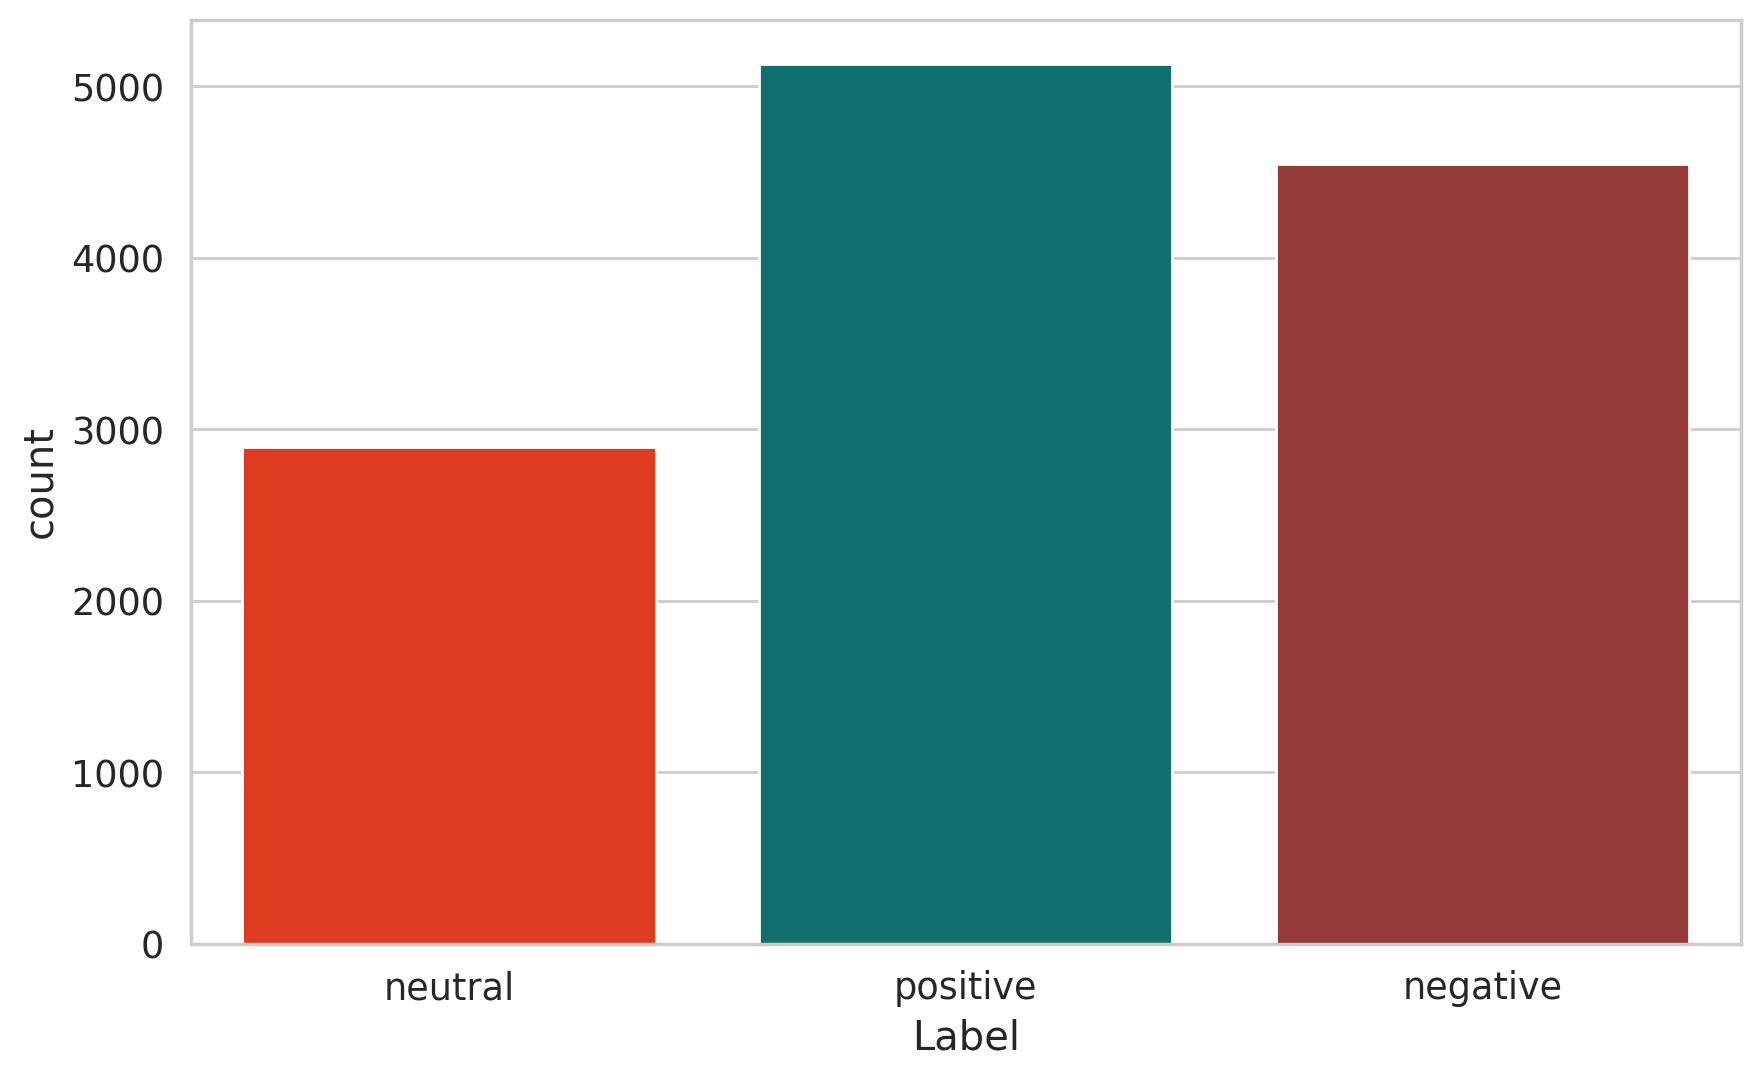

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))

Toxic_count = df_train['Label'].value_counts()
#sns.countplot(x='Score', data=df, order=Toxic_count.index)
#sns.countplot(x='Score', data=df, order=Toxic_count.index, color='blue')
sns.countplot(x='Label', data=df_train, palette=['#FF2400', 'teal','#A52A2A','Seagreen'])
# Rename the x-axis tick labels
new_labels = class_names# Replace with your desired labels
plt.gca().set_xticklabels(new_labels)

plt.show()


In [23]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [24]:
PRE_TRAINED_MODEL_NAME = 'csebuetnlp/banglabert' #sagorsarker/bangla-bert-base #bert-base-multilingual-cased #csebuetnlp/banglabert #neuropark/sahajBERT

In [25]:
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")#BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) #AutoTokenizer.from_pretrained("csebuetnlp/banglabert") PreTrainedTokenizerFast.from_pretrained("neuropark/sahajBERT")

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [26]:
pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-y75qf_mh
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-y75qf_mh
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6857 sha256=5101b760c32f1e5fe25fc91a863706e354475efe70e7b00f02403b5d3e577769
  Stored in directory: /tmp/pip-ephem-wheel-cache-910t7uei/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186459 sha256=7a6020d1ee60847856faaab42780b16e80c2256c

In [27]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
import torch

In [28]:
sample_txt= "আমি কৃতজ্ঞ কারণ আপনি আমার জন্য অনেক কিছু করেছেন।"

In [29]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

### Choosing Sequence Length


In [30]:
token_lens = []

for txt in df_train.Data:
  txt = normalize(txt) # this normalization step is required before tokenizing the text
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


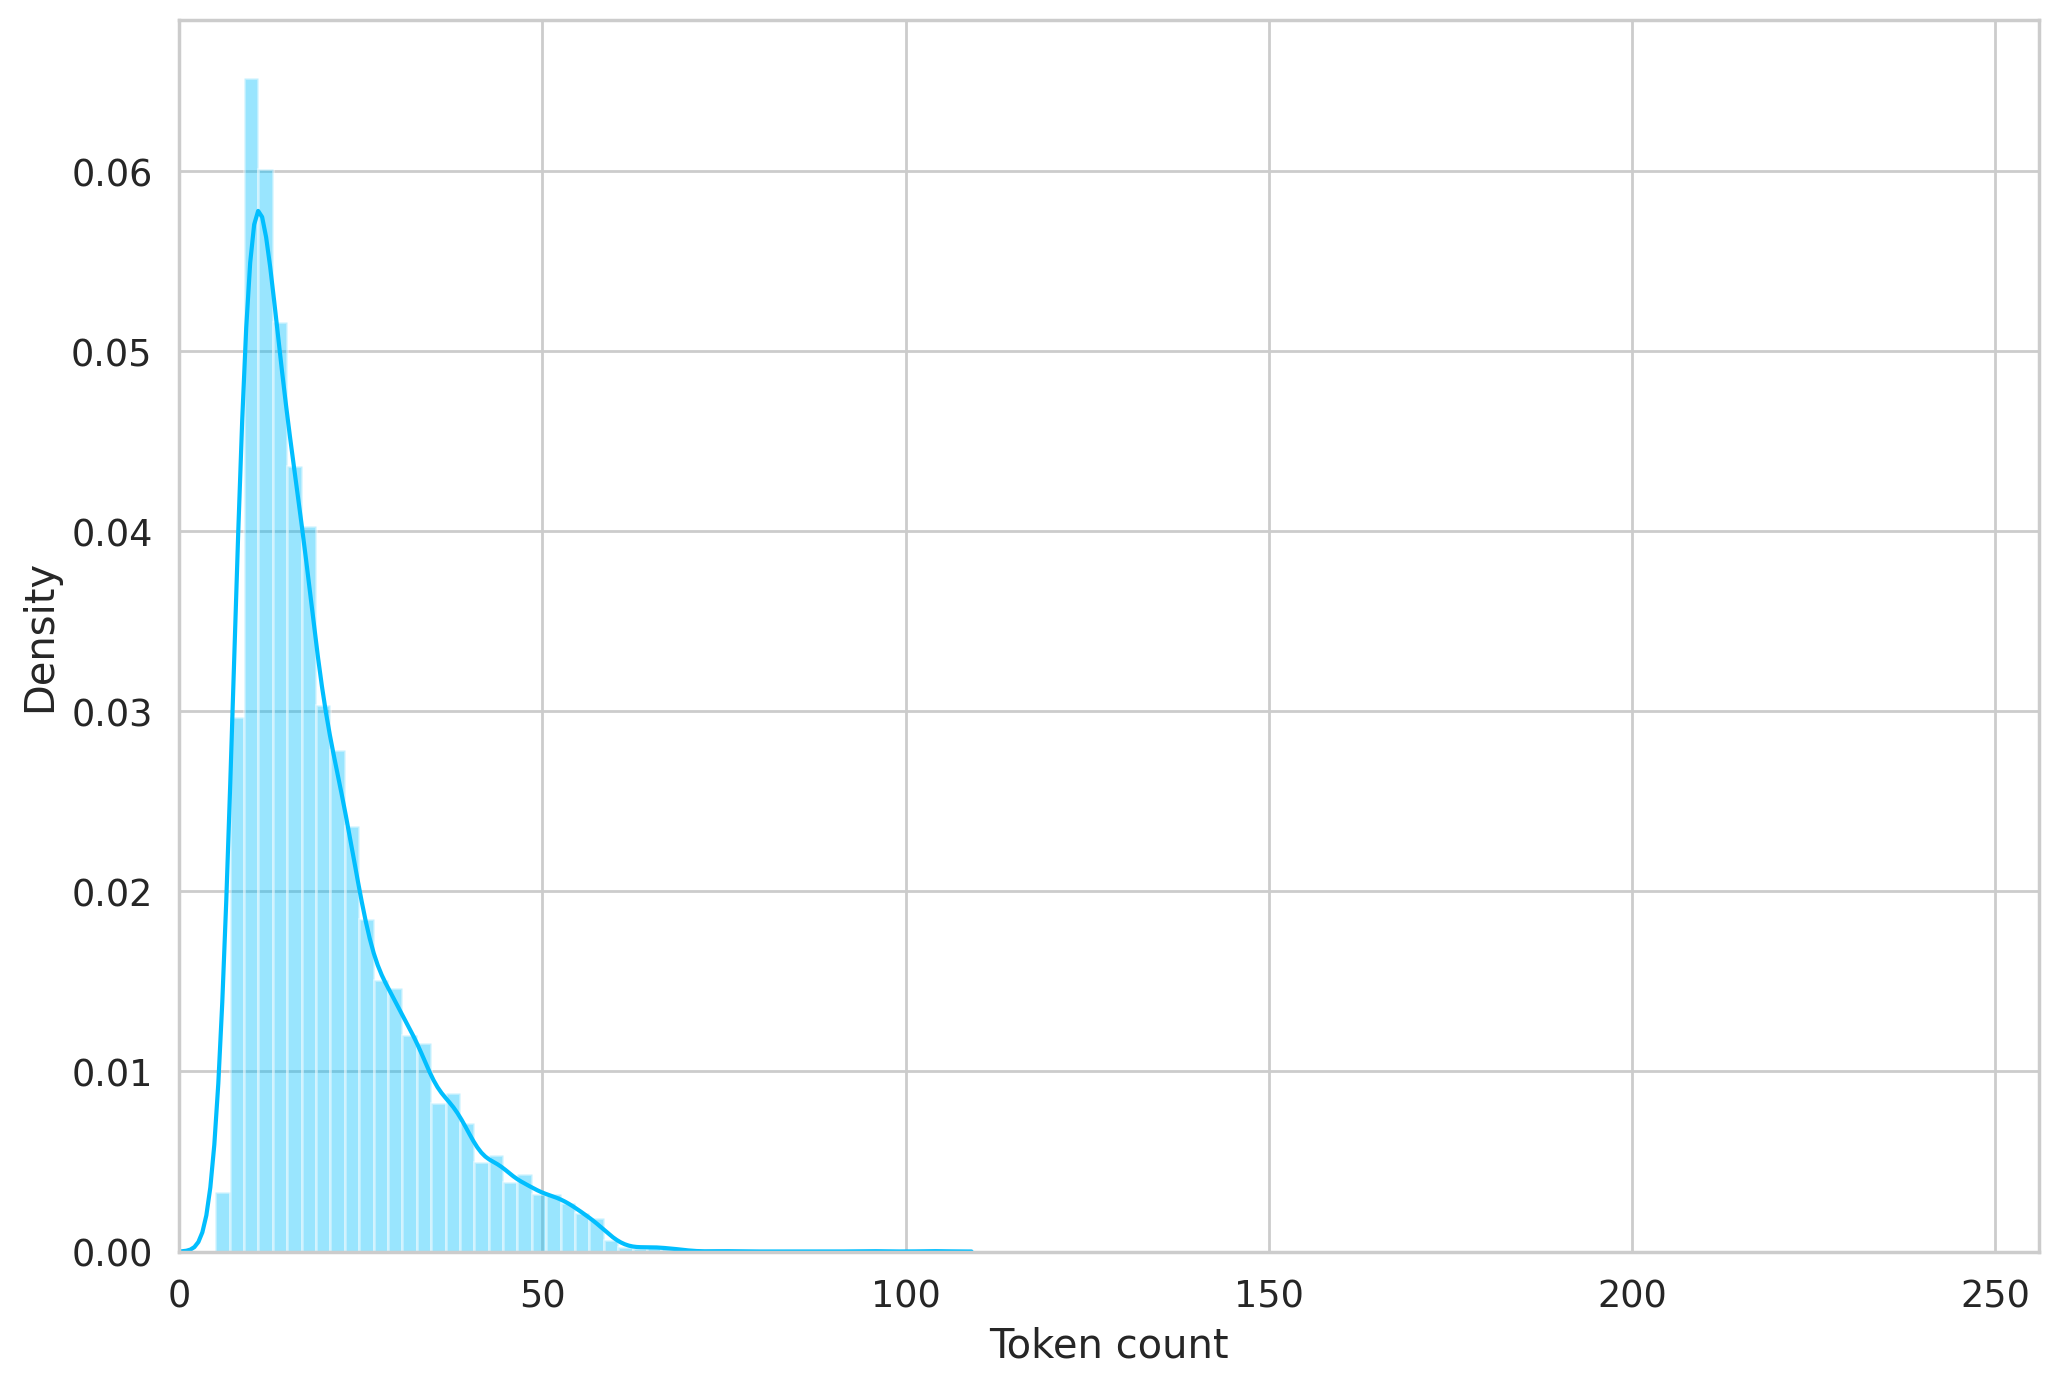

In [31]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [32]:
MAX_LEN = 80

In [33]:
class GPReviewDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    review = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'Data': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [34]:
df_train.shape, df_val.shape, df_test.shape

((12575, 2), (1567, 2), (1586, 2))

In [35]:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    comments=df.Data.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [36]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [37]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['Data', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])


In [39]:
bert_model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME) #BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [40]:
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [41]:
torch.cuda.empty_cache()

In [42]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [43]:
PRE_TRAINED_MODEL_NAME

'csebuetnlp/banglabert'

In [44]:
bert_model.config.hidden_size

768

In [45]:
last_hidden_state

ElectraForPreTrainingOutput(loss=None, logits=tensor([[-14.3940,  -4.4122,  -4.3277,  -3.2799,  -1.9589,  -5.0296,  -4.4236,
          -3.4212,  -2.1917,  -3.7347,  -4.1614, -14.3940,   3.5823,   2.7211,
           3.2465,   2.1568,   2.1993,   1.0032,   1.8768,   1.0918,   0.1768,
           1.5221,   3.9135,   2.8866,   2.2538,   1.7030, -12.2174,   4.5514,
          -0.4338,   0.7459,  -0.3823,   1.3115]], grad_fn=<SqueezeBackward1>), hidden_states=None, attentions=None)



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [46]:
class sentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(sentimentClassifier, self).__init__()
        self.electra = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(80, n_classes)  # Adjust the input size

    def forward(self, input_ids, attention_mask):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        pooled_output = outputs.logits  # Access logits for pooled output
        output = self.drop(pooled_output)
        return self.out(output)


In [47]:
model = sentimentClassifier(len(class_names))
model = model.to(device)

In [48]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 80])
torch.Size([16, 80])


In [49]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[4.3266e-01, 9.8011e-03, 5.5754e-01],
        [5.5788e-03, 1.1064e-01, 8.8379e-01],
        [9.8219e-01, 1.4749e-03, 1.6335e-02],
        [9.7098e-01, 2.9013e-02, 4.9781e-06],
        [7.9492e-01, 1.9712e-01, 7.9545e-03],
        [9.8732e-01, 1.0156e-02, 2.5272e-03],
        [2.3225e-06, 2.1791e-05, 9.9998e-01],
        [9.4256e-01, 5.4137e-02, 3.3034e-03],
        [9.9106e-01, 4.6000e-06, 8.9376e-03],
        [4.1214e-02, 4.5914e-01, 4.9964e-01],
        [6.8485e-02, 7.3084e-01, 2.0067e-01],
        [2.9022e-01, 4.9689e-01, 2.1289e-01],
        [6.1871e-01, 3.2100e-01, 6.0289e-02],
        [4.7869e-02, 8.9039e-01, 6.1741e-02],
        [9.1321e-01, 5.4686e-06, 8.6786e-02],
        [9.3371e-01, 1.2967e-02, 5.3319e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [50]:
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

# ***Training***

In [51]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [52]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  #tqdm for progress monitoring
  data_loader = tqdm(data_loader, desc="Training", unit="batch")

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    # Update tqdm description with the current loss
    data_loader.set_postfix(loss=np.mean(losses))

  return correct_predictions.double() / n_examples, np.mean(losses)


In [53]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    
    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


In [54]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\nTrain loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'\nVal   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.18batch/s, loss=0.849]



Train loss 0.8487546577784245 accuracy 0.627117296222664


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.26batch/s, loss=0.663]



Val   loss 0.6629349631922585 accuracy 0.7281429483088705

Epoch 2/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.19batch/s, loss=0.598]



Train loss 0.5981403699964664 accuracy 0.7516500994035785


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.30batch/s, loss=0.613]



Val   loss 0.6125075508441243 accuracy 0.7421825143586471

Epoch 3/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.19batch/s, loss=0.433]



Train loss 0.4327951576181571 accuracy 0.833479125248509


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.18batch/s, loss=0.68] 



Val   loss 0.6798182852870348 accuracy 0.7492022973835355

Epoch 4/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.19batch/s, loss=0.287]



Train loss 0.28690233796185627 accuracy 0.894234592445328


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.27batch/s, loss=0.931]



Val   loss 0.931291628134798 accuracy 0.7613273771537972

Epoch 5/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.19batch/s, loss=0.203]



Train loss 0.20296103746139116 accuracy 0.9339165009940358


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.19batch/s, loss=1.08] 



Val   loss 1.0833887045784873 accuracy 0.7657945118059988

Epoch 6/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.19batch/s, loss=0.169]



Train loss 0.1688637530110528 accuracy 0.9498210735586481


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.41batch/s, loss=1.77]



Val   loss 1.7664634656465175 accuracy 0.7498404594767072

Epoch 7/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.20batch/s, loss=0.14] 



Train loss 0.13996544480844958 accuracy 0.9619880715705765


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.02batch/s, loss=1.87]



Val   loss 1.8711128173281952 accuracy 0.7498404594767072

Epoch 8/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.18batch/s, loss=0.121] 



Train loss 0.12077999312537141 accuracy 0.9683499005964215


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.19batch/s, loss=1.87]



Val   loss 1.8677608144222473 accuracy 0.7606892150606255

Epoch 9/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.18batch/s, loss=0.104] 



Train loss 0.10393587902749361 accuracy 0.9752683896620278


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.29batch/s, loss=2.2] 



Val   loss 2.1968183604506204 accuracy 0.7645181876196554

Epoch 10/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.18batch/s, loss=0.0893]



Train loss 0.08925346979598477 accuracy 0.9776540755467197


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.12batch/s, loss=2]   



Val   loss 1.9978255971657986 accuracy 0.7562220804084238

Epoch 11/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.19batch/s, loss=0.0764]



Train loss 0.07636660118134704 accuracy 0.9797216699801193


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.26batch/s, loss=2.76]



Val   loss 2.762625410169249 accuracy 0.7549457562220805

Epoch 12/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.17batch/s, loss=0.0692]



Train loss 0.06923300202742824 accuracy 0.9813916500994035


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.11batch/s, loss=2.52]



Val   loss 2.522481966137631 accuracy 0.7638800255264838

Epoch 13/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.17batch/s, loss=0.0554]



Train loss 0.05541071573783307 accuracy 0.9835387673956263


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.01batch/s, loss=3.41]



Val   loss 3.412170788141951 accuracy 0.7657945118059988

Epoch 14/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.20batch/s, loss=0.0555]



Train loss 0.055532363955223665 accuracy 0.9837773359840954


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.30batch/s, loss=3.11]



Val   loss 3.1139643808864816 accuracy 0.7677089980855137

Epoch 15/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.18batch/s, loss=0.0483]



Train loss 0.048349886792834106 accuracy 0.9852087475149105


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.22batch/s, loss=2.68]



Val   loss 2.6782785670793787 accuracy 0.7651563497128271

Epoch 16/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.18batch/s, loss=0.0348]



Train loss 0.03483506319946812 accuracy 0.9869582504970179


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.34batch/s, loss=3.51] 



Val   loss 3.5078185501375367 accuracy 0.7606892150606255

Epoch 17/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.19batch/s, loss=0.0356]



Train loss 0.035621281481526074 accuracy 0.9859244532803181


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.28batch/s, loss=2.88]



Val   loss 2.88112097006524 accuracy 0.7619655392469687

Epoch 18/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.20batch/s, loss=0.034] 



Train loss 0.033970987099056625 accuracy 0.9861630218687872


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.31batch/s, loss=3.26]



Val   loss 3.2639254467119048 accuracy 0.7651563497128271

Epoch 19/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.20batch/s, loss=0.0247]



Train loss 0.02473751368074481 accuracy 0.9887872763419483


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.42batch/s, loss=3.55]



Val   loss 3.552046230176882 accuracy 0.7606892150606255

Epoch 20/20
----------


Training: 100%|██████████| 786/786 [01:49<00:00,  7.20batch/s, loss=0.0253]



Train loss 0.025261681637089167 accuracy 0.9891053677932405


Evaluating: 100%|██████████| 98/98 [00:04<00:00, 21.40batch/s, loss=3.6] 



Val   loss 3.603185436403265 accuracy 0.7613273771537972

CPU times: user 37min 31s, sys: 30.9 s, total: 38min 2s
Wall time: 38min 5s


In [55]:
model=sentimentClassifier(len(class_names))

In [56]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

# **Evaluation**



In [57]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 100/100 [00:04<00:00, 21.40batch/s, loss=3.82]


0.7358133669609079

In [58]:
def get_predictions(model, data_loader):
  model = model.eval()

  toxic_comments = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["Data"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      toxic_comments.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return toxic_comments, predictions, prediction_probs, real_values

In [59]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# ***Let's have a look at the classification report***

In [60]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

              precision    recall  f1-score   support

     neutral     0.5735    0.4321    0.4929       361
    positive     0.7907    0.8028    0.7967       654
    negative     0.7477    0.8511    0.7961       571

    accuracy                         0.7358      1586
   macro avg     0.7040    0.6953    0.6952      1586
weighted avg     0.7258    0.7358    0.7273      1586



# ***Confusion Matrix***

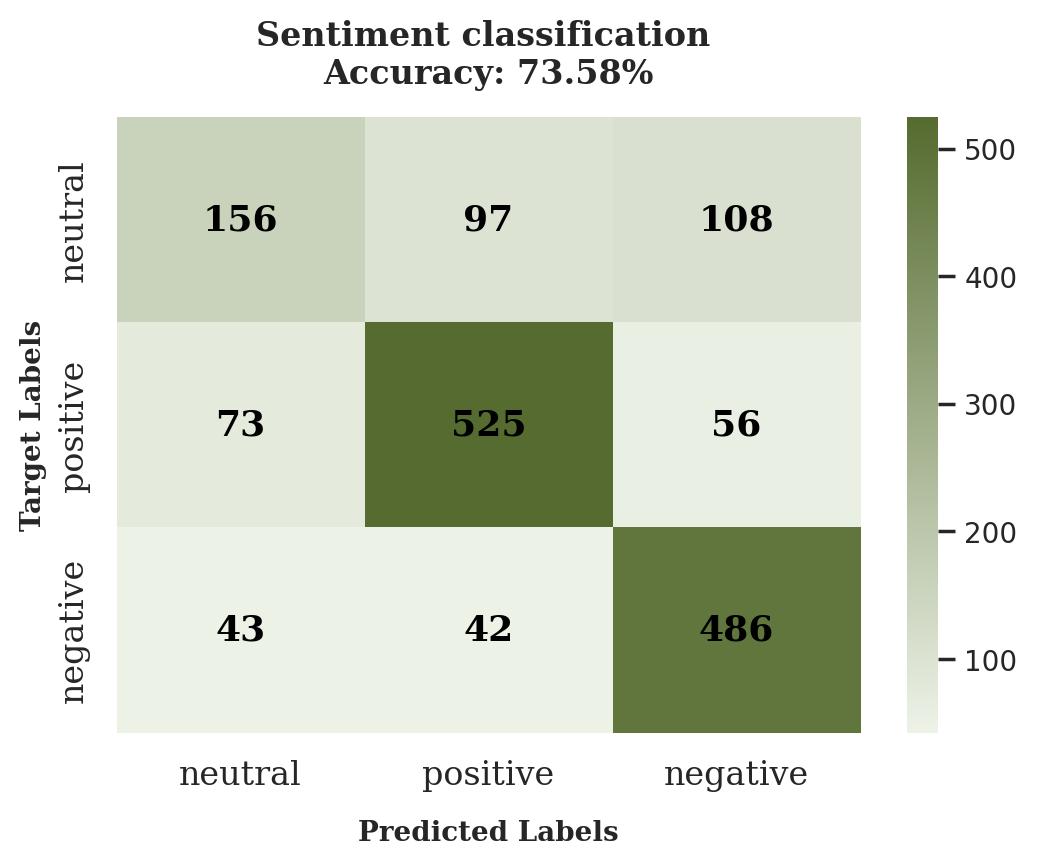

In [62]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.light_palette("DarkOliveGreen", as_cmap=True)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('Sentiment classification \nAccuracy: {:.2f}%'.format(accuracy_percentage),
                  fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()


In [63]:
idx = 40

review_text = y_review_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [64]:
print("\n".join(wrap(review_text)))
print()
print(f'True Label: {class_names[true_label]}')

একটা জিজ্ঞাস‍্য বিষয় ছিল , খাবারের পরিমাণ বেশ অনেক দেখছি , একটা থালি
দুজনে শেয়ার করা যায় নাকি

True Label: neutral


Now we can look at the confidence of each sentiment of our model:

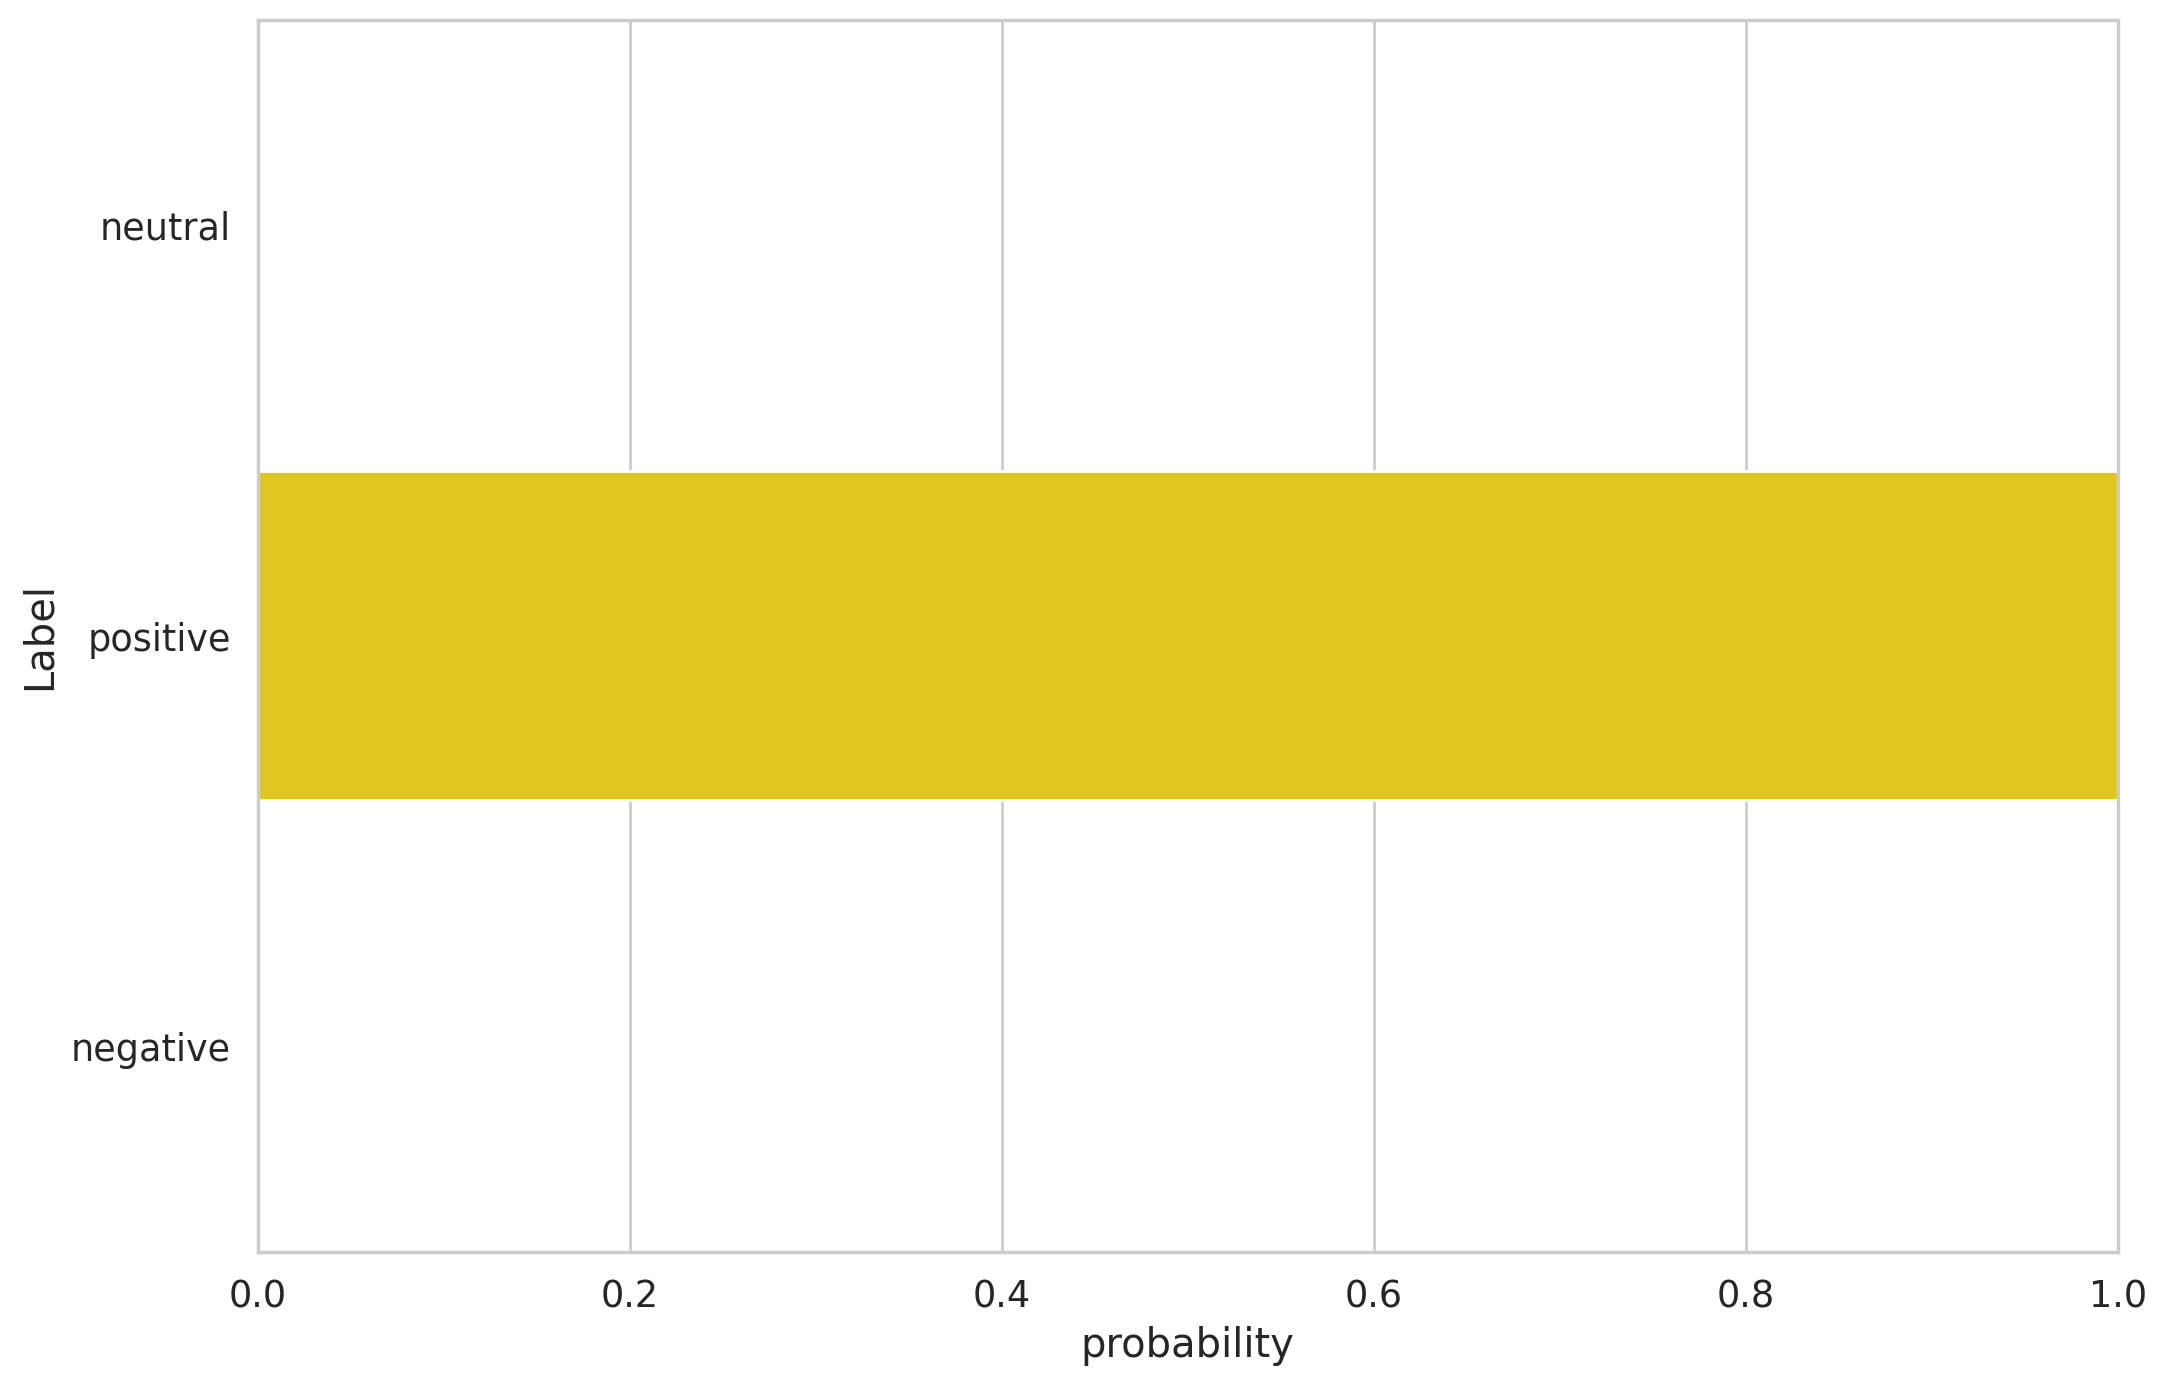

In [65]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Label')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [66]:
Raw_Text = "চুরের সাত দিন হাওদের একদিন"

In [67]:
encoded_review = tokenizer.encode_plus(
  Raw_Text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [68]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw Text: {Raw_Text}')
print(f'Prediction  : {class_names[prediction]}')

Raw Text: চুরের সাত দিন হাওদের একদিন
Prediction  : neutral


In [69]:
review_text = "মুকাফফি অনেক ভালো ছেলে"

In [70]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [71]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Context text: {review_text}')
print(f'Prediction   : {class_names[prediction]}')

Context text: এগুলো খাওয়া হারাম?
Prediction   : neutral
